In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.optimize import curve_fit
from pingouin import partial_corr
from scipy.stats import pearsonr
import pickle

from tqdm.auto import tqdm
import matplotlib as mpl

In [102]:
def zipfs_law(rank, a, b):
    return 1 / (rank + b) ** a

In [103]:
class NeutralModel():
    def __init__(self, N=10, S=30, mu=0.3, 
                 k=0.2, p=100000, t=10) -> None:
        self.history = []
        self.meaning_lookup = {}
        self.age_lookup = {}

        self.N = N
        self.S = S
        self.mu = mu # innovation rate
        self.k = k # reuse rate
        self.p = p
        self.t = t

        self.initialize()

    def initialize(self):
        self.meaning_lookup = {i: 1 for i in range(self.N)}
        self.age_lookup = {i: 0 for i in range(self.N)}
        self.pool = np.random.choice(list(self.meaning_lookup.keys()), size=self.p, replace=True)

        while sum(self.meaning_lookup.values()) < self.S:
            self.meaning_lookup[np.random.choice(self.pool)] += 1

    def step(self, t):
        self.pool = np.random.choice(self.pool, size=self.p, replace=True)
        invent_index = np.where(np.random.binomial(1, self.mu, size=self.p) == 1)[0]

        for i in invent_index:
            new_index = max(self.meaning_lookup.keys()) + 1
            self.meaning_lookup[new_index] = 1
            self.age_lookup[new_index] = 1
            self.pool[i] = new_index

        unique_types, counts = np.unique(self.pool, return_counts=True)
        frequency_lookup = dict(zip(unique_types, counts))
        reuse_index = np.where(np.random.binomial(1, self.k, size=len(unique_types)) == 1)[0]

        for i in reuse_index:
            self.meaning_lookup[unique_types[i]] += 1

        for rt in unique_types:
            self.age_lookup[rt] += 1
            self.history.append({
                'step': t,
                'id': rt,
                'age': self.age_lookup[rt],
                'count': frequency_lookup.get(rt, 0),
                'meanings': self.meaning_lookup[rt],
                'extinct': 0
            })

    def run(self):
        for i in range(self.t):
            self.step(i)

In [254]:
# create an empty heatmap with y and x from 0.01 to 0.1 with 0.02 steps

heatmap_lm = np.zeros((10, 10))
heatmap_fm = np.zeros((10, 10))
heatmap_lm_p = np.zeros((10, 10))
heatmap_fm_p = np.zeros((10, 10))

# iterate over the heatmap and fill it with the values
for i, mu in enumerate(tqdm(np.linspace(0.01, 0.1, 10))):
    for j, k in enumerate(np.linspace(0.01, 0.1, 10)):
        a = NeutralModel(N=305, S=600, mu=mu, k=k, p=10000, t=300)
        a.run()
        df = pd.DataFrame(a.history)
        df = pd.DataFrame(a.history, columns=['step', 'id', 'age', 'count', 'meanings', 'extinct'])
        df = df[df['step'] == a.t - 1]
        df['frequency'] = df['count'] / sum(df['count'])
        
        heatmap_lm[i, j] = pearsonr(df['age'], df['meanings'])[0]
        heatmap_fm[i, j] = pearsonr(df['frequency'], df['meanings'])[0]
        heatmap_lm_p[i, j] = partial_corr(data=df, x='age', y='meanings', covar='frequency')['r']['pearson']
        heatmap_fm_p[i, j] = partial_corr(data=df, x='frequency', y='meanings', covar='age')['r']['pearson']

  0%|          | 0/10 [00:00<?, ?it/s]

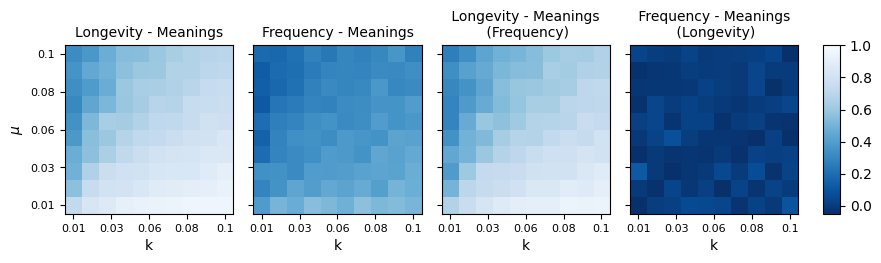

In [274]:
fig = plt.figure(figsize=(10, 3))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 4),
                 axes_pad=0.2,
                 cbar_mode='single',
                 cbar_location='right',
                 cbar_pad=0.25,
                #  label_mode = 'all',
                 cbar_size = "10%",
                 )

heatmaps = [heatmap_lm, heatmap_fm, heatmap_lm_p, heatmap_fm_p]
titles = ['Longevity - Meanings', 
          'Frequency - Meanings', 
          ' Longevity - Meanings \n (Frequency)', 
          ' Frequency - Meanings \n (Longevity)']

for ax, heatmap, title in zip(grid, heatmaps, titles):
    im = ax.matshow(heatmap, cmap='Blues_r', vmin=-0.05, vmax=1)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('k')
    ax.set_ylabel('$\mu$')
    ax.set_xticks(np.linspace(0, 9, 5))
    ax.set_yticks(np.linspace(0, 9, 5))
    ax.set_xticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))
    ax.set_yticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))  
    # make tikz font size smaller
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.xaxis.set_ticks_position('bottom')
    # turn the y axis upside down
    ax.invert_yaxis()

# add colorbar
ax.cax.colorbar(im)

plt.savefig('../figures/heatmap.pdf', bbox_inches='tight')
plt.show()

In [275]:
# # pickle heatmaps
# with open('../data/heatmaps.pkl', 'wb') as f:
#     pickle.dump(heatmaps, f)
#     f.close()

In [105]:
# # pickle heatmap
# with open('heatmap.pickle', 'wb') as handle:
#     pickle.dump(heatmap, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
# unpickle heatmap from ../data
with open('../data/heatmap.pickle', 'rb') as handle:
    heatmap = pickle.load(handle)

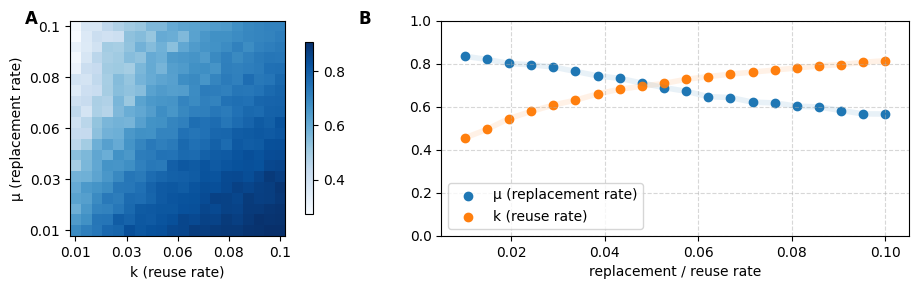

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1.2]})

# Plot the heatmap
im = ax1.imshow(heatmap, cmap='Blues', interpolation='nearest')
# ax1.colorbar()
ax1.set_xlabel('k (reuse rate)')
ax1.set_ylabel('μ (replacement rate)')
ax1.set_xticks(np.linspace(0, 19, 5))
ax1.set_yticks(np.linspace(0, 19, 5))
ax1.set_xticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))
ax1.set_yticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))
ax1.invert_yaxis()

fig.colorbar(im, ax=ax1, shrink=0.8)

# Add panel handle A to the top left corner of ax1
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Plot the line plots
mus = np.linspace(0.01, 0.1, 20)
ks = np.linspace(0.01, 0.1, 20)

ax2.plot(mus, heatmap.mean(axis=1), linewidth=4, alpha=0.1)
ax2.scatter(mus, heatmap.mean(axis=1), label='μ (replacement rate)', alpha=1)
ax2.plot(ks, heatmap.mean(axis=0), linewidth=4, alpha=0.1)
ax2.scatter(ks, heatmap.mean(axis=0), label='k (reuse rate)', alpha=1)
ax2.set_ylim(0, 1)
ax2.set_xlim(0.005, 0.105)
ax2.set_xlabel('replacement / reuse rate')
ax2.grid(alpha=0.5, linestyle='--')
ax2.legend()

# Add panel handle B to the top left corner of ax2
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# plt.savefig('../figures/figure_model_1.pdf')
plt.show()


In [276]:
model = NeutralModel(N=6000, S=3042, mu=0.01, k=0.02, p=100000, t=300)
model.run()
df = pd.DataFrame(model.history, columns=['step', 'id', 'age', 'count', 'meanings', 'extinct'])
df = df[df['step'] == model.t - 1]
df['frequency'] = df['count'] / sum(df['count'])

In [278]:
partial_corr(data=df, x='meanings', y='frequency', covar='age', method='pearson')

,n,r,CI95%,p-val
pearson,8153,-0.003419,"[-0.03, 0.02]",0.757563


In [279]:
# compute partial correlation between frequency and number of meanings controlling for age
partial_corr(data=df, x='meanings', y='age', covar='frequency', method='pearson')

,n,r,CI95%,p-val
pearson,8153,0.74925,"[0.74, 0.76]",0.0


In [280]:
partial_corr(data=df, x='meanings', y='age', method='pearson')

,n,r,CI95%,p-val
pearson,8153,0.805453,"[0.8, 0.81]",0.0


In [281]:
partial_corr(data=df, x='meanings', y='frequency', method='pearson')

,n,r,CI95%,p-val
pearson,8153,0.44634,"[0.43, 0.46]",0.0


[  1.17682449 219.17684913]


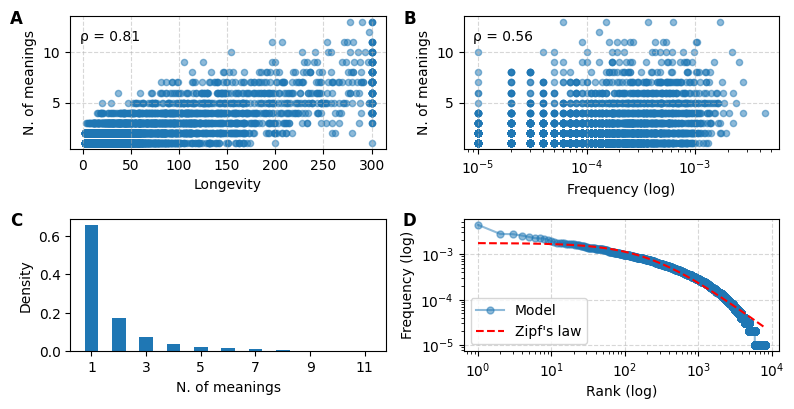

In [287]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4.2))

# Scatter plot of age vs meanings
axs[0, 0].scatter(df['age'], df['meanings'], alpha=0.5, s=20)
axs[0, 0].set_xlabel('Longevity')
axs[0, 0].set_ylabel('N. of meanings')
axs[0, 0].grid(alpha=0.5, linestyle='--')
# add pearson correlation coefficient
axs[0, 0].text(0.22, 0.9, f'ρ = {np.round(df.corr().iloc[4, 2], 2)}', 
               transform=axs[0, 0].transAxes, fontsize=10, va='top', ha='right')
axs[0, 0].text(-0.15, 1.05, 'A', transform=axs[0, 0].transAxes, 
               fontsize=12, fontweight='bold', va='top', ha='right')

axs[0, 1].scatter(df['frequency'], df['meanings'],  alpha=0.5, s=20)
axs[0, 1].set_xscale('log')
axs[0, 1].set_ylabel('N. of meanings')
axs[0, 1].set_xlabel('Frequency (log)')
axs[0, 1].grid(alpha=0.5, linestyle='--')
# add pearson correlation coefficient
axs[0, 1].text(0.22, 0.9, f'ρ = {np.round(df.corr().iloc[2, 3], 2)}', 
               transform=axs[0, 1].transAxes, fontsize=10, va='top', ha='right')
axs[0, 1].text(-0.15, 1.05, 'B', transform=axs[0, 1].transAxes,
                fontsize=12, fontweight='bold', va='top', ha='right')

# Bar plot of number of meanings distribution
axs[1, 0].hist(df['meanings'], bins=range(1, int(df['meanings'].max())),
                align='left', rwidth=0.5, density=True)
axs[1, 0].set_xticks(range(1, int(df['meanings'].max()), 2))
axs[1, 0].set_xlabel('N. of meanings')
axs[1, 0].set_ylabel('Density')
axs[1, 0].text(-0.15, 1.05, 'C', transform=axs[1, 0].transAxes, 
               fontsize=12, fontweight='bold', va='top', ha='right')

# Bar plot of rank frequency distribution
axs[1, 1].plot(range(1, len(df) + 1), sorted(df['frequency'], reverse=True)
                , marker='o', linestyle='-', alpha=0.5, markersize=5, label='Model')
# approximate zipf's law using frequency and rank and find a and b
x = np.linspace(1, len(df), len(df))
y = sorted(df['frequency'], reverse=True)
popt, pcov = curve_fit(zipfs_law, x, y, p0=[1, 2.7])
print(popt)
axs[1, 1].plot(x, zipfs_law(x, *popt), 'r--', label=f'Zipf\'s law')
# log scale y
axs[1, 1].set_yscale('log')
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlabel('Rank (log)')
axs[1, 1].set_ylabel('Frequency (log)')
axs[1, 1].grid(alpha=0.5, linestyle='--')
axs[1, 1].legend()
# add label D
axs[1, 1].text(-0.15, 1.05, 'D', transform=axs[1, 1].transAxes, 
               fontsize=12, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# Save to pdf
plt.savefig('../figures/figure_model_2.pdf', bbox_inches='tight')
plt.show()

In [315]:
df['frequency_neg_log'] = -np.log(df['frequency'])
# round to 0 
df['frequency_neg_log'] = df['frequency_neg_log'].round(0)

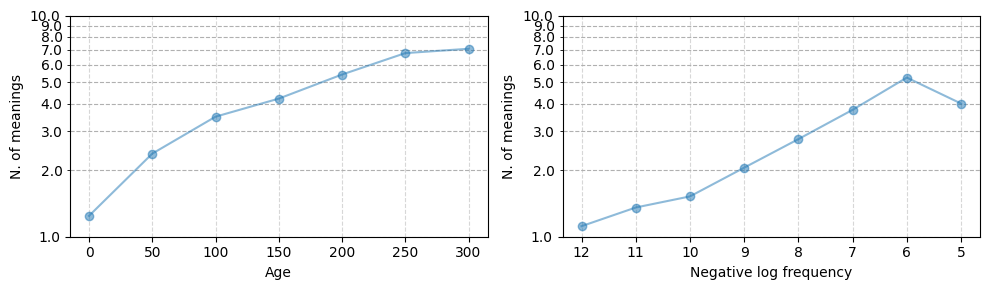

In [333]:
df_freq = df.groupby('frequency_neg_log').agg({'meanings': 'mean'}).reset_index()
df_age = df.groupby('age_bin').mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot the first subplot: Negative log frequency vs Meanings
axs[1].plot(df_freq['frequency_neg_log'], df_freq['meanings'], alpha=0.5, marker='o')
axs[1].set_xlabel('Negative log frequency')
axs[1].set_ylabel('N. of meanings')
axs[1].set_yscale('log')
axs[1].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[1].yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
axs[1].set_ylim(1, 10)
# add grid with vertical lines and horizontal lines
axs[1].grid(alpha=0.5, linestyle='--')
axs[1].grid(which='minor', axis='y', linestyle='--')
# reverse x axis
axs[1].invert_xaxis()

# Plot the second subplot: Age vs Meanings
axs[0].plot(df_age['age_bin'], df_age['meanings'], alpha=0.5, marker='o')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('N. of meanings')
axs[0].set_xticks(range(0, 350, 50))
axs[0].set_yscale('log')
axs[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(1, 10)
# add grid with vertical lines and horizontal lines
axs[0].grid(alpha=0.5, linestyle='--')
axs[0].grid(which='minor', axis='y', linestyle='--')

plt.tight_layout()
plt.show()

In [385]:
def growth(mu, k):
    model = NeutralModel(N=600, S=305, mu=mu, k=k, p=10000, t=100)
    model.run()

    df_full = pd.DataFrame(model.history, columns=['step', 'id', 'age', 'count', 'meanings', 'extinct'])
    # group by step and count unique ids and sum the number of meanings
    df_grouped = df_full.groupby('step').agg({'id': 'nunique', 'meanings': 'sum'}).reset_index()
    del df_full
    df_grouped = df_grouped.reset_index()
    return df_grouped

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

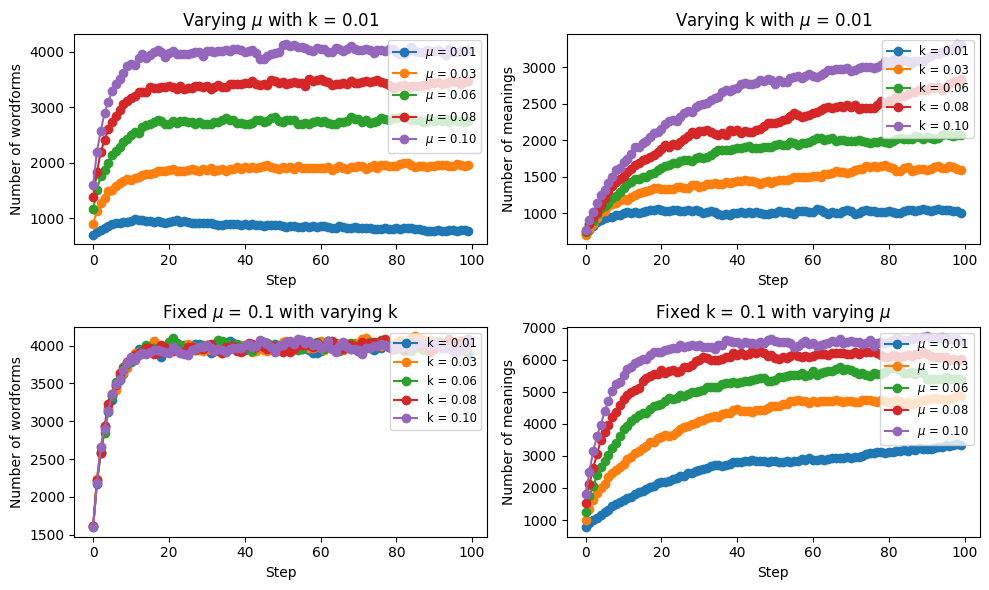

In [390]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot for varying mu
axs[0, 0].set_title('Varying $\mu$ with k = 0.01')
axs[0, 0].set_xlabel('Step')
axs[0, 0].set_ylabel('Number of wordforms')

for i in tqdm(np.linspace(0.01, 0.1, 5)):
    df = growth(mu=i, k=0.01)
    axs[0, 0].plot(df['step'], df['id'], 
                 alpha=1, 
                 label=f'$\mu$ = {i:.2f}',
                 marker='o')

axs[0, 0].legend(loc='upper right', fontsize='small')

# Plot for varying k with mu = 0.01
axs[0, 1].set_title('Varying k with $\mu$ = 0.01')
axs[0, 1].set_xlabel('Step')
axs[0, 1].set_ylabel('Number of meanings')

for j in tqdm(np.linspace(0.01, 0.1, 5)):
    df = growth(mu=0.01, k=j)
    axs[0, 1].plot(df['step'], df['meanings'], 
                 alpha=1, 
                 label=f'k = {j:.2f}',
                 marker='o')

axs[0, 1].legend(loc='upper right', fontsize='small')

# Plot for fixed mu = 0.1
axs[1, 0].set_title('Fixed $\mu$ = 0.1 with varying k')
axs[1, 0].set_xlabel('Step')
axs[1, 0].set_ylabel('Number of wordforms')

for j in tqdm(np.linspace(0.01, 0.1, 5)):
    df = growth(mu=0.1, k=j)
    axs[1, 0].plot(df['step'], df['id'], 
                 alpha=1, 
                 label=f'k = {j:.2f}',
                 marker='o')

axs[1, 0].legend(loc='upper right', fontsize='small')

# Plot for fixed k = 0.1
axs[1, 1].set_title('Fixed k = 0.1 with varying $\mu$')
axs[1, 1].set_xlabel('Step')
axs[1, 1].set_ylabel('Number of meanings')

for i in tqdm(np.linspace(0.01, 0.1, 5)):
    df = growth(mu=i, k=0.1)
    axs[1, 1].plot(df['step'], df['meanings'], 
                 alpha=1, 
                 label=f'$\mu$ = {i:.2f}',
                 marker='o')

axs[1, 1].legend(loc='upper right', fontsize='small')

plt.tight_layout()
# save to pdf
plt.savefig('../figures/figure_model_growth.pdf', bbox_inches='tight')
plt.show()

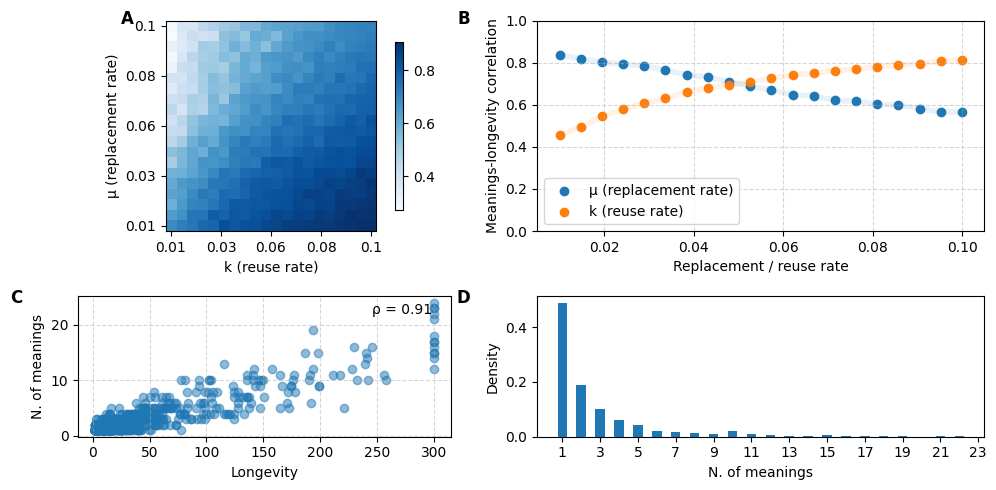

In [11]:
# First set of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'height_ratios': [3, 2], 'width_ratios': [1, 1.2]})

# Panel A
im = axs[0, 0].imshow(heatmap, cmap='Blues', interpolation='nearest')
axs[0, 0].set_xlabel('k (reuse rate)')
axs[0, 0].set_ylabel('μ (replacement rate)')
axs[0, 0].set_xticks(np.linspace(0, 19, 5))
axs[0, 0].set_yticks(np.linspace(0, 19, 5))
axs[0, 0].set_xticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))
axs[0, 0].set_yticklabels(np.round(np.linspace(0.01, 0.1, 5), 2))
axs[0, 0].invert_yaxis()
fig.colorbar(im, ax=axs[0, 0], shrink=0.8)
axs[0, 0].text(-0.15, 1.05, 'A', transform=axs[0, 0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Panel B with width ratio 1:1.2
mus = np.linspace(0.01, 0.1, 20)
ks = np.linspace(0.01, 0.1, 20)
axs[0, 1].plot(mus, heatmap.mean(axis=1), linewidth=4, alpha=0.1)
axs[0, 1].scatter(mus, heatmap.mean(axis=1), label='μ (replacement rate)', alpha=1)
axs[0, 1].plot(ks, heatmap.mean(axis=0), linewidth=4, alpha=0.1)
axs[0, 1].scatter(ks, heatmap.mean(axis=0), label='k (reuse rate)', alpha=1)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xlim(0.005, 0.105)
axs[0, 1].set_xlabel('Replacement / reuse rate')
axs[0, 1].set_ylabel('Meanings-longevity correlation')
axs[0, 1].grid(alpha=0.5, linestyle='--')
axs[0, 1].legend()
axs[0, 1].text(-0.15, 1.05, 'B', transform=axs[0, 1].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Second set of plots
# Panel B with width ratio 1:1
axs[1, 0].scatter(df['age'], df['meanings'], alpha=0.5)
axs[1, 0].set_xlabel('Longevity')
axs[1, 0].set_ylabel('N. of meanings')
axs[1, 0].grid(alpha=0.5, linestyle='--')
axs[1, 0].text(-0.15, 1.05, 'C', transform=axs[1, 0].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
# add correlation coefficient in the top right corner
axs[1, 0].text(0.95, 0.95, 'ρ = ' + str(round(np.corrcoef(df['age'], df['meanings'])[0, 1], 2)), 
               transform=axs[1, 0].transAxes, fontsize=10, color='black', va='top', ha='right')

# Panel C
axs[1, 1].hist(df['meanings'], bins=range(1, int(df['meanings'].max())), 
               align='left', rwidth=0.5, density=True)
axs[1, 1].set_xticks(range(1, int(df['meanings'].max()), 2))
axs[1, 1].set_xlabel('N. of meanings')
axs[1, 1].set_ylabel('Density')
axs[1, 1].text(-0.15, 1.05, 'D', transform=axs[1, 1].transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/combined_model.pdf', bbox_inches='tight')
plt.show()